<h2><center>AI in Healthcare</center></h2>
<h3><center>Smart Home Activities Prediction</h3>

The objective of this lab is to learn to apply the LSTM to the data collectd from Halmstad University's Smart Home

## Imports

In [1]:
from scipy.io import loadmat
import numpy as np
from numpy import array
from pandas import DataFrame, concat
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import label_binarize
from itertools import cycle

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.preprocessing.sequence import TimeseriesGenerator

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, TimeDistributed, RepeatVector
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from sklearn.metrics import confusion_matrix, plot_roc_curve, roc_curve, auc, roc_auc_score

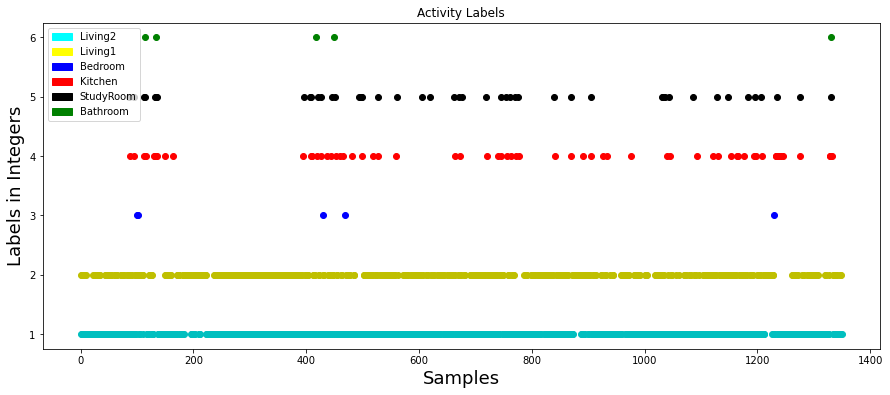

In [2]:
data = loadmat(f"{os.getcwd()}/Data.mat")

DatesVectors = np.array(data['DatesVectors'])
SensorsVals = np.array(data['SensorsVals'])
Labels = np.array(data['Labels'])
Labels = Labels[7401:,:]

SensorsVals = SensorsVals.astype('int')
SensorsVals = SensorsVals[7401:,:]
SensorsVals = np.concatenate(SensorsVals,axis=0)

TrainLabels=Labels
TrainLabels=np.ravel(TrainLabels)
TrainLabels=np.array(TrainLabels)

Classes=['Living2','Living1','Bedroom','Kitchen','Study','Bathroom']
Indexes=[] # creat an empty list
for kk in range(len(Classes)):
    lbl=Classes[kk]
    idx=np.argwhere(TrainLabels==lbl)
    Indexes.append(idx)
    

Colors=['c','y','b','r','k','g']
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
plt.title('Activity Labels')
for kk in range(len(Indexes)):
    idx=np.array(Indexes[kk])
    for jj in range(len(idx)):
        ax.plot(idx[jj],SensorsVals[idx[jj]],'o',color=Colors[kk],label=Classes[kk])
        
ax.set_ylabel('Labels in Integers',fontsize=18)
ax.set_xlabel('Samples',fontsize=18)

blue_patch = mpatches.Patch(color='blue', label='Bedroom')
red_patch = mpatches.Patch(color='red', label='Kitchen')
green_patch = mpatches.Patch(color='green', label='Bathroom')
cyan_patch = mpatches.Patch(color='cyan', label='Living2')
yellow_patch = mpatches.Patch(color='yellow', label='Living1')
black_patch = mpatches.Patch(color='black', label='StudyRoom')


ax.legend(handles=[cyan_patch,yellow_patch,blue_patch,red_patch,black_patch,green_patch])
plt.show()


## Instructions
You are supposed to do a sequence of integers prediction using LSTM.
First, try to visualize what you have in the SensorsVals. The values of SensorsVals are already concatanated into an array 
of integers.

You expose the LSTM to a sequence of observation. Then, the LSTM is going to do the prediciton of the sequence after some
training (sequence to sequence model).

You may try your own methodology. The suggestion is to:
- one hot encode the SensorsVals variables (encoded)
- Frame the encoded sequences for learning 




### Encoding

In [3]:
'''
With courtesy of https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
'''
labels = [label[0] for label in Labels]
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
#print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(labels_encoded)

/home/stud/j/jonfoc16/miniconda3/envs/aih/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### Splitting data

In [4]:
'''
With courtesy of https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
'''
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
x, y = split_sequence(labels_encoded, 5)

In [6]:
print(f'Input sequence: {SensorsVals[:5]}\nCorresponding output sequence: {SensorsVals[5]}\n')
print(f'Encoded input sequence: \n{x[0]}\nEncoded corresponding output sequence: {y[0]}')

Input sequence: [2 1 2 1 2]
Corresponding output sequence: 1

Encoded input sequence: 
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]]
Encoded corresponding output sequence: [0. 0. 0. 0. 1. 0.]


One-hot encoding translation:</br>
[0 0 0 0 1 0] = 1</br>
[0 0 0 1 0 0] = 2</br>
[0 1 0 0 0 0] = 3</br>
[0 0 1 0 0 0] = 4</br>
[0 0 0 0 0 1] = 5</br>
[1 0 0 0 0 0] = 6</br>

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Construct LSTM model

LSTM info: </br>
 [samples, timesteps, features] - Input and output required format. </br>
 Samples= the amount of sequences. </br>
 Timesteps = Length of a given sequence.</br> 
 Features = Amount of separate values. </br>
 

 Encoder outputs a 2D array. Decoder expects a 3D array as input

In [8]:
sequence_length = 5
n_features = 6
def createLSTM():    
    input_ = Input(shape=(sequence_length, n_features))
    lstm1 = LSTM(units=50, activation='relu')(input_)
    output_ = Dense(units=n_features, activation='softmax')(lstm1)
    
    model = Model(inputs=input_, outputs=output_, name='LSTM')
    
    return model

In [9]:
model = createLSTM()
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                11400     
_________________________________________________________________
dense (Dense)                (None, 6)                 306       
Total params: 11,706
Trainable params: 11,706
Non-trainable params: 0
_________________________________________________________________


### Train model

In [11]:
EPOCHS = 50

model.fit(x_train, 
          y_train, 
          epochs=EPOCHS, 
          validation_data=(x_test, y_test)
         )

Epoch 1/50
34/34 [==============================] - 1s 18ms/step - loss: 1.7326 - accuracy: 0.4210 - val_loss: 1.6633 - val_accuracy: 0.5465
Epoch 2/50
34/34 [==============================] - 0s 14ms/step - loss: 1.5463 - accuracy: 0.5697 - val_loss: 1.3779 - val_accuracy: 0.5465
Epoch 3/50
34/34 [==============================] - 0s 14ms/step - loss: 1.1413 - accuracy: 0.5697 - val_loss: 1.0586 - val_accuracy: 0.5465
Epoch 4/50
34/34 [==============================] - 0s 14ms/step - loss: 0.9983 - accuracy: 0.5697 - val_loss: 1.0258 - val_accuracy: 0.5465
Epoch 5/50
34/34 [==============================] - 0s 14ms/step - loss: 0.9793 - accuracy: 0.5697 - val_loss: 1.0153 - val_accuracy: 0.5465
Epoch 6/50
34/34 [==============================] - 0s 14ms/step - loss: 0.9684 - accuracy: 0.5697 - val_loss: 1.0059 - val_accuracy: 0.5465
Epoch 7/50
34/34 [==============================] - 0s 14ms/step - loss: 0.9618 - accuracy: 0.5697 - val_loss: 1.0039 - val_accuracy: 0.5465
Epoch 8/50
34

### Make predictions

In [12]:
predictions = model.predict(x_test)

In [13]:
# Converts the predictions into one-hot encoded format.
def oneHotPredictions(predictions):
    return_array = np.zeros(predictions.shape)
    row = 0
    for true, predicted in zip(y_test, predictions):
        return_array[row][np.argmax(predicted, axis=0)] = 1
        row+=1
        
    return return_array

In [14]:
predictions = oneHotPredictions(predictions)

### Confusion matrix

In [15]:
conf_mat = confusion_matrix(y_true=y_test.argmax(axis=1), y_pred=predictions.argmax(axis=1))

In [16]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(accuracy))
    plt.show()

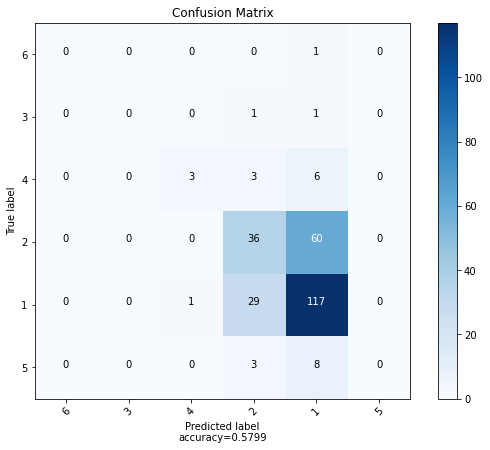

In [17]:
plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['6', '3', '4', '2', '1', '5'],
                      title        = "Confusion Matrix")